#Final Research Project

In this notebook we will find the summary of the work done in the NET 7429 course. In our research we focused on how the Graph Embedding Techniques worked.


*   For this scenario, GCN and Node2Vec were selected to be applied to the Cora dataset.
*   To then be able to see the results of each technique and be able to compare them.



#Libraries

First we need to install some requirements

In [1]:
%pip install stellargraph[demos]

     |████████████████████████████████| 435 kB 5.2 MB/s 
     |████████████████████████████████| 482 kB 39.8 MB/s 
     |████████████████████████████████| 41 kB 432 kB/s 
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28582 sha256=593b87a43b1989eee73cc5da11578014b6d4baaa27ce9723a90a290a58d5fb27
  Stored in directory: /root/.cache/pip/wheels/6b/f5/21/cdd12e476182b4b0b98326cdb9efa02ddbd5d87ca5de051c84
Successfully built mplleaflet


Import the libraries

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import os
import seaborn as sns
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models import Word2Vec

%matplotlib inline

In [3]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

--2022-02-09 13:54:52--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-09 13:54:52 (25.3 MB/s) - ‘visualization.py’ saved [13008/13008]



#Cora Dataset

Here we load the Cora Dataset

In [4]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


The next two lines will help us in the future, dont modify it

In [7]:
lstnodes = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']
lstnodes_arr = np.array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'])

#GCN

##Select the nodes to train

Here we’re taking 2000 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=2000, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [9]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,604
Probabilistic_Methods,315
Genetic_Algorithms,309
Theory,259
Case_Based,220
Reinforcement_Learning,160
Rule_Learning,133


Converting to numeric arrays

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

##Creating the GCN layers

Assign the GCN algorithm

In [11]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [12]:
train_gen = generator.flow(train_subjects.index, train_targets)

Especify the machine learning model to use


*   layer_sizes: the number of hidden GCN layers and their sizes.
*   activations: the activation to apply to each GCN layer’s output. 
*   dropout: the rate of dropout for the input of each GCN layer. 




In [13]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

 Expose the input and output tensors of the GCN model for node prediction

In [14]:
x_inp, x_out = gcn.in_out_tensors()

This activation function ensures that the final outputs for each input node will be a vector of “probabilities”

In [15]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

##Training the model

 Create the Keras model 

In [16]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
val_gen = generator.flow(val_subjects.index, val_targets)

 We will use EarlyStopping to stop training if the validation accuracy stops improving

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

Lets train the model

In [19]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 3s - loss: 1.9642 - acc: 0.1135 - val_loss: 1.9285 - val_acc: 0.2280 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.9291 - acc: 0.2010 - val_loss: 1.9042 - val_acc: 0.3500 - 268ms/epoch - 268ms/step
Epoch 3/200
1/1 - 0s - loss: 1.9034 - acc: 0.3525 - val_loss: 1.8682 - val_acc: 0.3560 - 269ms/epoch - 269ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8677 - acc: 0.3675 - val_loss: 1.8211 - val_acc: 0.3700 - 253ms/epoch - 253ms/step
Epoch 5/200
1/1 - 0s - loss: 1.8225 - acc: 0.3725 - val_loss: 1.7690 - val_acc: 0.3920 - 303ms/epoch - 303ms/step
Epoch 6/200
1/1 - 0s - loss: 1.7771 - acc: 0.3910 - val_loss: 1.7109 - val_acc: 0.4140 - 233ms/epoch - 233ms/step
Epoch 7/200
1/1 - 0s - loss: 1.7136 - acc: 0.3980 - val_loss: 1.6461 - val_acc: 0.4380 - 281ms/epoch - 281ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6624 - acc: 0.4105 - val_loss: 1.5735 - val_acc: 0.4520 - 323ms/epoch - 323ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5944 - acc: 0.4440 - val_loss: 1.4931 - val_acc: 0.5040 - 346ms

Show the graphic of the trainning process

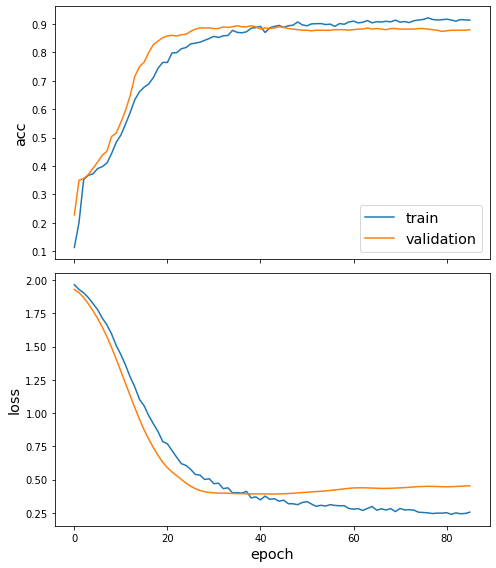

In [20]:
sg.utils.plot_history(history)

Here we all collecting the accuracy of the last 19 trials in order to plot it later and compare it with Node2Vec

In [21]:
arr = history.history['acc']
acurr_gcn = arr[len(arr)-19:len(arr)]
print(len(acurr_gcn))

19


##Making predictions with the model

Here we get the predictions for all nodes

In [22]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [23]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

These predictions will be the categories in a integer value, so to get final categories we will use the inverse_transform method to turn these values back to the original categories.

In [24]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Here we can see that with GCN we have a 91% of accuracy (it may change with several runs of the code)


In [25]:
accuracy_score(node_predictions,node_subjects)

0.912850812407681

Lets see a comparison chart where we can see the predicted categories, in comparison with the real ones.

In [26]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


##Node Embeddings

Create a model that computes node embeddings.

In [27]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

We will compute embeddings for every node using the all_gen data.

In [28]:
emb = embedding_model.predict(all_gen)

We will use TSE for dimensionality reduction task

In [29]:
transform = TSNE

In [30]:
X = emb.squeeze(0)

 Compute the reduced vectors, as two columns of the new values.

In [31]:
trans = TSNE(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

##Graph

Plot the graph of the classification.

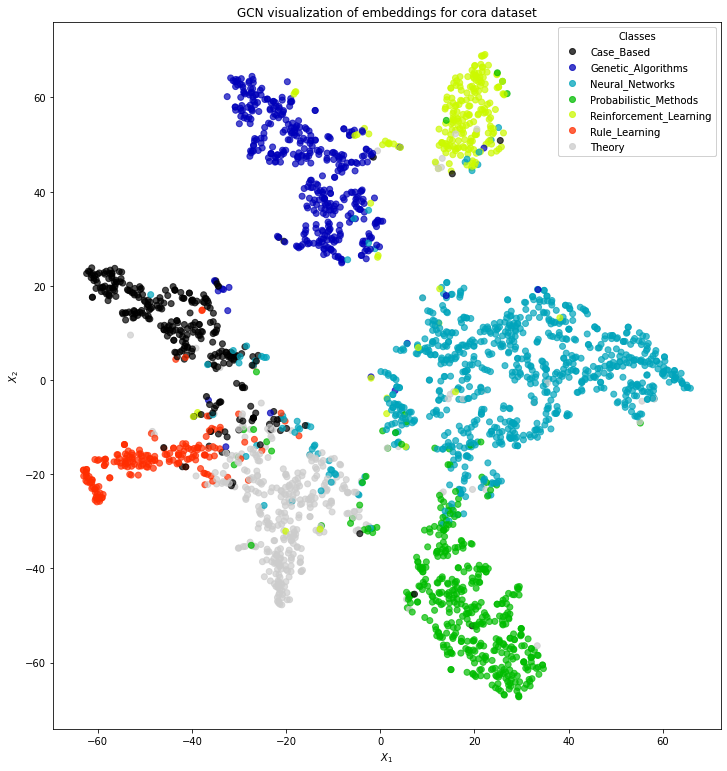

In [52]:
fig, ax = plt.subplots(figsize=(13, 13))
sca = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="nipy_spectral",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"GCN visualization of embeddings for cora dataset",
)
legend1 = ax.legend(handles=sca.legend_elements()[0], labels=lstnodes, loc="best", title="Classes")
ax.add_artist(legend1)

##Confusion Matrix

Lets encodes the values to plot it in the confusion Matrix

In [33]:
test_encoder = LabelEncoder()
train_encoder = LabelEncoder()

In [34]:
test_encoder.fit(node_predictions)
label_train = test_encoder.transform(node_predictions)
node_predictions = label_train.tolist()

train_encoder.fit(node_subjects)
label_train = train_encoder.transform(node_subjects)
node_gcn = label_train.tolist()

Plot the confusion matrix

Normalized confusion matrix
[[0.89690722 0.01718213 0.02749141 0.         0.00343643 0.03092784
  0.02405498]
 [0.00719424 0.95923261 0.00959233 0.         0.02158273 0.
  0.00239808]
 [0.00724638 0.00966184 0.92149758 0.02294686 0.01449275 0.00120773
  0.02294686]
 [0.01179245 0.00235849 0.04716981 0.91981132 0.00235849 0.
  0.01650943]
 [0.00487805 0.0097561  0.03414634 0.01463415 0.92195122 0.
  0.01463415]
 [0.05714286 0.00571429 0.00571429 0.         0.01142857 0.90285714
  0.01714286]
 [0.0326087  0.00271739 0.04076087 0.03804348 0.00815217 0.0326087
  0.8451087 ]]


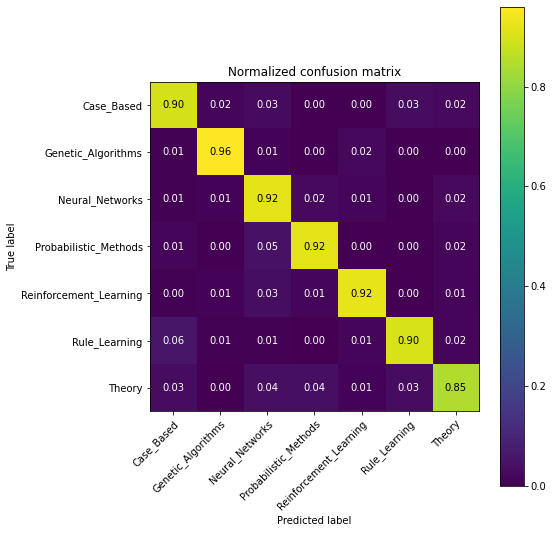

In [35]:
plot_conf_mat(node_predictions, node_gcn, lstnodes_arr)

#Node2Vec

##RandomWalk

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter p to 0.5 and q to 0.25.

In [96]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=0.25,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 27080


##Word2Vec

We use the Word2Vec to learn representations for each node in the graph.

In [97]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [98]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

##Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the TSNE algorithm.

In [99]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [100]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


##Training the Model

The node embeddings calculated using Word2Vec will be to train a classifier to predict the subject of a paper.

In [101]:
# X will hold the input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

We split the data into train and test sets, and train the classifier on the training data.

In [102]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 19/19 [00:06<00:00,  2.74it/s]


Print the accuracy values obtained

In [103]:
print(len(nv_micro_f1_scores))

19


Here we can see that with Node2Vec we have a 75% of accuracy (it may change with several runs of the code)

In [104]:
accuracy_score(y_test, y_pred)

0.7481542247744053

##Graph

Plot the graph

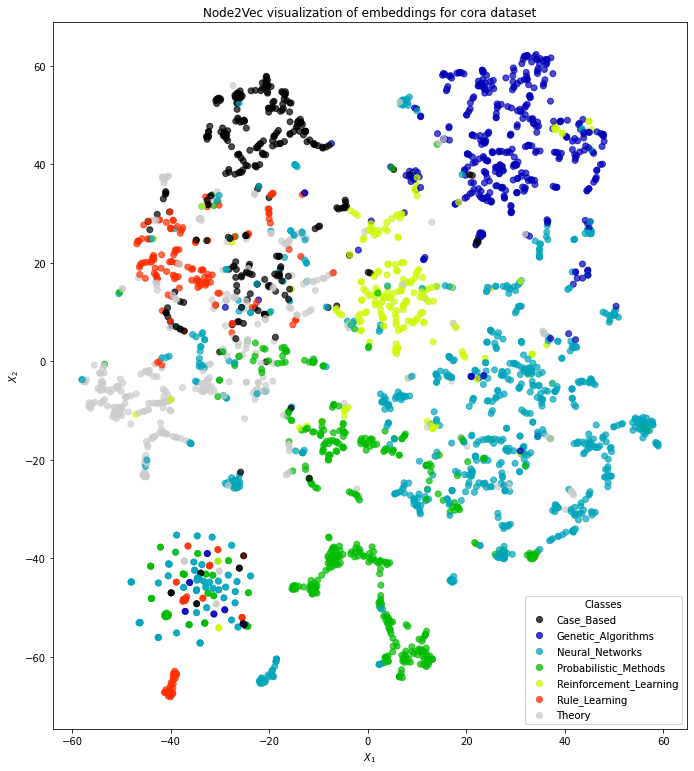

In [105]:
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

fig, ax = plt.subplots(figsize=(13, 13))
sca = ax.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="nipy_spectral",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"Node2Vec visualization of embeddings for cora dataset",
)
legend1 = ax.legend(handles=sca.legend_elements()[0], labels=lstnodes, loc="best", title="Classes")
ax.add_artist(legend1)



##Confusion Matrix

Lets encodes the values to plot it in the confusion Matrix

In [106]:
y_test_encoder = LabelEncoder()
pred_encoder = LabelEncoder()

In [107]:
y_test_encoder.fit(y_test)
label_train = y_test_encoder.transform(y_test)
y_test = label_train.tolist()

pred_encoder.fit(y_pred)
label_train = pred_encoder.transform(y_pred)
y_pred = label_train.tolist()

Plot the confusion matrix

Normalized confusion matrix
[[0.54814815 0.04814815 0.21481481 0.07037037 0.00740741 0.02962963
  0.08148148]
 [0.         0.89893617 0.08776596 0.00797872 0.00265957 0.
  0.00265957]
 [0.00675676 0.02297297 0.88378378 0.05540541 0.00945946 0.00540541
  0.01621622]
 [0.0026738  0.00802139 0.18181818 0.75935829 0.00534759 0.
  0.04278075]
 [0.015      0.11       0.29       0.055      0.515      0.
  0.015     ]
 [0.01242236 0.         0.20496894 0.02484472 0.         0.62111801
  0.13664596]
 [0.0126183  0.02208202 0.22082019 0.04416404 0.01577287 0.06309148
  0.6214511 ]]


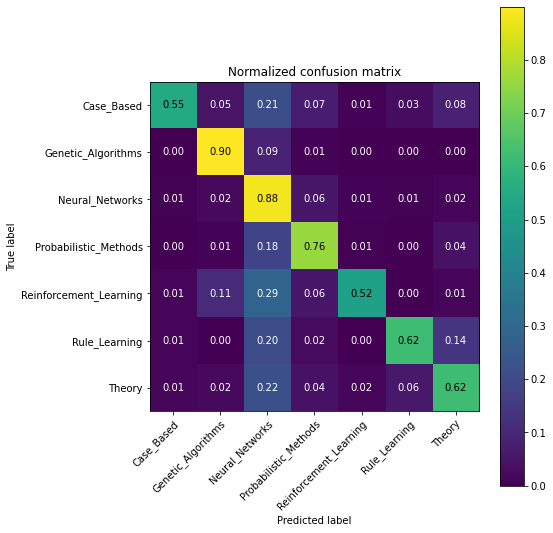

In [108]:
plot_conf_mat(y_test, y_pred, lstnodes_arr)

#GCN vs Node2Vec

[]

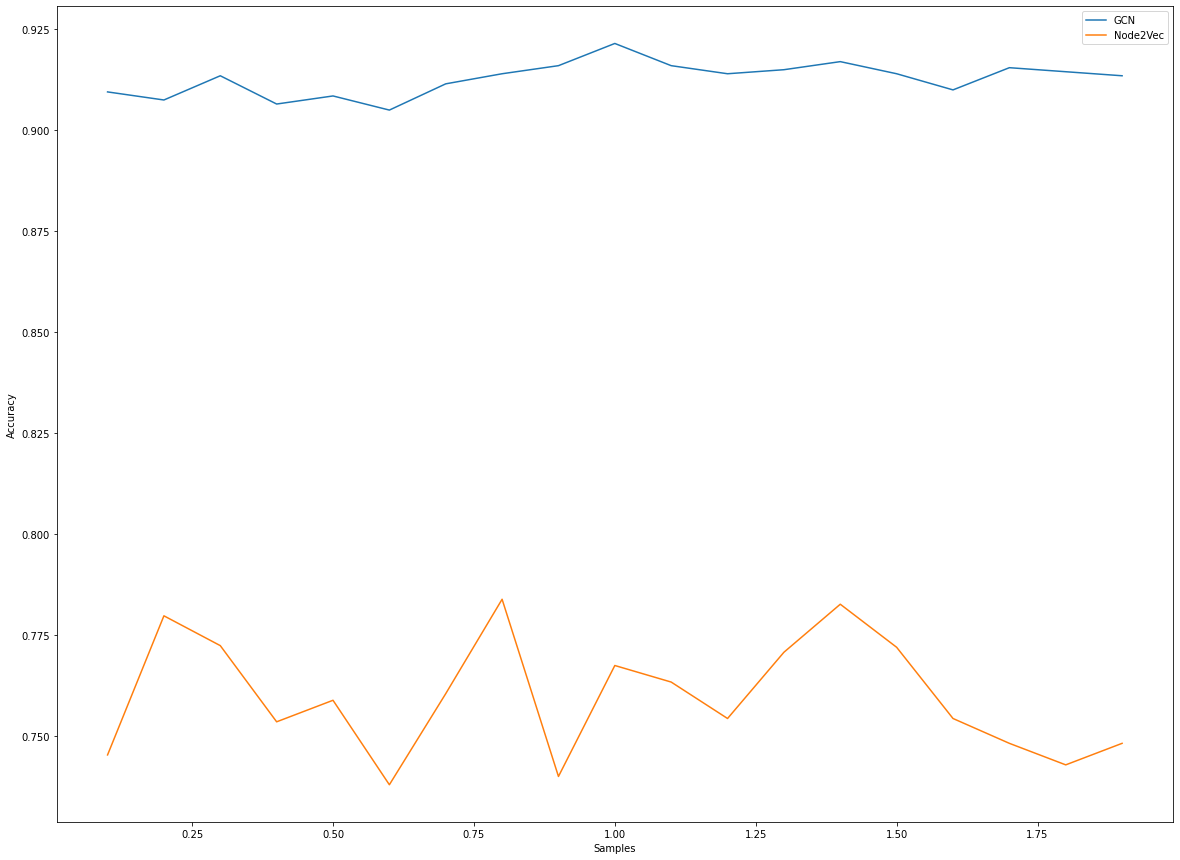

In [109]:
plt.figure(figsize=(20, 15))
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = acurr_gcn, label='GCN')
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = nv_micro_f1_scores, label='Node2Vec')
plt.xlabel('Samples')
plt.ylabel('Accuracy')
plt.plot()